# Starbucks Rewards: Predicting Consumer Responses

## Project Overview

This project is an experiment that determines how do we take this experimental data and discover what are the offers that excite people? So, the Capstone Project is about discovering what is the most valuable offer there is, not just for the customers as a whole but at an individual personal level.

Link to an academic paper where machine learning was applied to this type of problem: http://ceur-ws.org/Vol-3026/paper18.pdf

## Problem Statement

To predict if someone will reply to an offer, transaction data and demographic information must be combined. GitHub
customers will also have access to the data and in the Data Sets section of the proposal, it is clearly stated that the repository and data sets are available.

Using Gradient Boosting, a supervised learning method, we will analyze the attributes of customers to create customer classifications.

This is a multi-class classification problem so the key metric we will use is f1-score. The simulating dataset only has one product, while Starbucks offers dozens of products. Therefore, this data set is a simplified version of the real Starbucks app.



In [1]:
from collections import defaultdict
import pandas as pd
import sagemaker
from sklearn.model_selection import train_test_split
from sagemaker.xgboost.estimator import XGBoost
from sklearn import preprocessing

## Data Exploration

### Dataset details

portfolio.json
* id (string) - offer id
* offer_type (string) - a type of offer ie BOGO, discount, informational
* difficulty (int) - the minimum required to spend to complete an offer
* reward (int) - the reward is given for completing an offer
* duration (int) - time for the offer to be open, in days
* channels (list of strings)

profile.json
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

transcript.json
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since the start of the test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

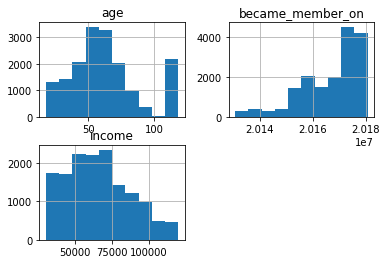

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

profile.hist()

## Data Preprocessing

We will handle missing values in the <strong>genders</strong> column in the `profile.json` data set by deleting rows

Pros:
Complete removal of data with missing values results in robust and highly accurate model
Deleting a particular row or a column with no specific information is better, since it does not have a high weightage

Cons:
Loss of information and data
Works poorly if the percentage of missing values is high (say 30%), compared to the whole dataset

In [3]:
profile.dropna(inplace=True)
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


### Note: We only consider customers who received offers.

In [4]:
new_transcript = transcript[transcript['event'].str.startswith('o')]
new_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
# Split / Explode a column of dictionaries into separate columns 
new_transcript = pd.concat([new_transcript.drop(['value'], axis=1), new_transcript['value'].apply(pd.Series)], axis=1)
new_transcript.head()

,person,event,time,offer id,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [6]:
new_transcript = new_transcript.dropna(subset = ["offer_id"])

temp1 = portfolio.rename(columns={"id": "offer_id"})
temp2 = profile.rename(columns={"person": "id"})

data = pd.merge(new_transcript, temp1, on="offer_id").rename(columns={"person": "id"})
data = pd.merge(data, temp2, on="id")

In [7]:
# Creating additional features
data['became_member_on'] = pd.to_datetime(data['became_member_on'],format='%Y%m%d')

data["year"] = data.became_member_on.dt.year
data["month"] = data.became_member_on.dt.month
data["day"] = data.became_member_on.dt.day

data.head()

,id,event,time,offer id,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income,year,month,day
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,2,"[web, email, mobile]",10,7,discount,M,42,2016-01-17,96000.0,2016,1,17
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,540,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10,"[web, email, mobile, social]",10,5,bogo,M,42,2016-01-17,96000.0,2016,1,17
2,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,354,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,3,"[web, email, mobile, social]",7,7,discount,M,42,2016-01-17,96000.0,2016,1,17
3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,474,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,5,"[web, email]",20,10,discount,M,42,2016-01-17,96000.0,2016,1,17
4,73ffefd41e9a4ca3ab26b2b3697c6eb7,offer completed,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,2,"[web, email, mobile]",10,7,discount,F,67,2015-09-29,67000.0,2015,9,29


In [8]:
to_drop = ['offer id',
           'event',
           'id',
           'became_member_on',
           'reward_y',
           'reward_x',
           'time',
           'offer_type']
           
data.drop(to_drop, inplace=True, axis=1)
print(data)

                               offer_id                      channels  \
0      2906b810c7d4411798c6938adc9daaa5          [web, email, mobile]   
1      4d5c57ea9a6940dd891ad53e9dbe8da0  [web, email, mobile, social]   
2      2298d6c36e964ae4a3e7e9706d1fb8c2  [web, email, mobile, social]   
3      0b1e1539f2cc45b7b9fa7c272da2e1d7                  [web, email]   
4      2906b810c7d4411798c6938adc9daaa5          [web, email, mobile]   
...                                 ...                           ...   
32439  0b1e1539f2cc45b7b9fa7c272da2e1d7                  [web, email]   
32440  0b1e1539f2cc45b7b9fa7c272da2e1d7                  [web, email]   
32441  0b1e1539f2cc45b7b9fa7c272da2e1d7                  [web, email]   
32442  0b1e1539f2cc45b7b9fa7c272da2e1d7                  [web, email]   
32443  0b1e1539f2cc45b7b9fa7c272da2e1d7                  [web, email]   

       difficulty  duration gender  age   income  year  month  day  
0              10         7      M   42  96000.0  2016

We will handle missing values in the <strong>income</strong> column in `data` by deleting rows. 

In [9]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32444 entries, 0 to 32443
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   offer_id    32444 non-null  object 
 1   channels    32444 non-null  object 
 2   difficulty  32444 non-null  int64  
 3   duration    32444 non-null  int64  
 4   gender      32444 non-null  object 
 5   age         32444 non-null  int64  
 6   income      32444 non-null  float64
 7   year        32444 non-null  int64  
 8   month       32444 non-null  int64  
 9   day         32444 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 2.7+ MB


#### Notice we only have 8 offers from previous 10 in the `portfolio.json` file. This is because two are merely informational

In [10]:
target_vals = {offer_id for offer_id in data['offer_id']}
print(target_vals)

{'ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', 'fafdcd668e3743c1bb461111dcafc2a4', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d', '2298d6c36e964ae4a3e7e9706d1fb8c2', '0b1e1539f2cc45b7b9fa7c272da2e1d7', '2906b810c7d4411798c6938adc9daaa5'}


## Set target to be offer_id

In [11]:
data['target'] = data['offer_id']
data.drop('offer_id', inplace=True, axis=1)
data.head()

,channels,difficulty,duration,gender,age,income,year,month,day,target
0,"[web, email, mobile]",10,7,M,42,96000.0,2016,1,17,2906b810c7d4411798c6938adc9daaa5
1,"[web, email, mobile, social]",10,5,M,42,96000.0,2016,1,17,4d5c57ea9a6940dd891ad53e9dbe8da0
2,"[web, email, mobile, social]",7,7,M,42,96000.0,2016,1,17,2298d6c36e964ae4a3e7e9706d1fb8c2
3,"[web, email]",20,10,M,42,96000.0,2016,1,17,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,"[web, email, mobile]",10,7,F,67,67000.0,2015,9,29,2906b810c7d4411798c6938adc9daaa5


In [12]:
# Convert object type to avoid error

lbl = preprocessing.LabelEncoder()
data['gender'] = lbl.fit_transform(data['gender'].astype(str))
data['target'] = lbl.fit_transform(data['target'].astype(str))
data['channels'] = lbl.fit_transform(data['gender'].astype(str))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32444 entries, 0 to 32443
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   channels    32444 non-null  int64  
 1   difficulty  32444 non-null  int64  
 2   duration    32444 non-null  int64  
 3   gender      32444 non-null  int64  
 4   age         32444 non-null  int64  
 5   income      32444 non-null  float64
 6   year        32444 non-null  int64  
 7   month       32444 non-null  int64  
 8   day         32444 non-null  int64  
 9   target      32444 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.7 MB


In [13]:
data = data.drop_duplicates()

## Class distributions of offers completed (Exploratory Visualization)

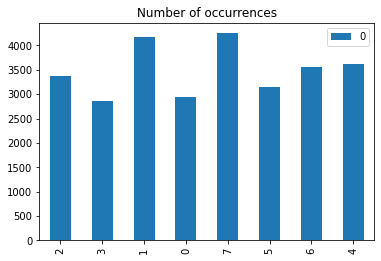

In [14]:
offer_count = defaultdict(int)
for offer in data['target']:
    if offer in offer_count:
        offer_count[offer]+=1
    else:
        offer_count[offer] = 1

class_count = pd.DataFrame.from_dict(offer_count, orient='index')
bar_plot = class_count.plot.bar(title="Number of occurrences")

In [15]:
data.to_csv('data.csv', index = False)

In [16]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [17]:
train.to_csv('data/train/train.csv', index = False)
test.to_csv('data/test/test.csv', index = False)

## Upload to S3 bucket

In [18]:
sagemaker_session = sagemaker.Session()

bucket = "my-project-bucket-123"
region ="us-east-1" 
role = "arn:aws:iam::657240468511:role/service-role/AmazonSageMaker-ExecutionRole-20211225T133929"

print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: my-project-bucket-123
AWS Region: us-east-1
RoleArn: arn:aws:iam::657240468511:role/service-role/AmazonSageMaker-ExecutionRole-20211225T133929


In [19]:
s3_path_to_data = sagemaker.Session().upload_data(bucket=bucket, 
                                                  path='data/train', 
                                                  key_prefix='train')

s3_path_to_data = sagemaker.Session().upload_data(bucket=bucket, 
                                                  path='data/test', 
                                                  key_prefix='test')


## Benchmark

We will be using multiclass logistic regression against which we can benchmark.

In [20]:
benchmark_data = pd.read_csv ('data.csv')
benchmark_train, benchmark_test = train_test_split(data, test_size=0.2, random_state=0)

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000 )
X = benchmark_train.iloc[:, :-1]
y = benchmark_train.iloc[:, -1:]
model.fit(X, y.values.ravel())


LogisticRegression(max_iter=10000, multi_class='multinomial', solver='saga')

In [22]:
from sklearn.metrics import f1_score

preds = model.predict(benchmark_test.iloc[:,:-1])
score=f1_score(benchmark_test["target"], preds, average='weighted')
print(f"f1-score: {score}")

f1-score: 0.2048716783909761


## Model Training
**Note:** You will need to use the `train.py` script to train your model.

In [23]:
output_path = 's3://{}/output'.format(bucket)
input_data = 's3://{}/'.format(bucket)

metric_definitions = [{'Name': 'validation:f1', 'Regex': '.*\[[0-9]+\].*#011validation-f1:([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'}]

xgb_estimator = XGBoost(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.3-1",
    output_path=output_path,

)

In [24]:
train_input = input_data + "train"
test_input = input_data + "test"

In [25]:
xgb_estimator.fit({'train': train_input, 'validation': test_input})

2022-01-16 17:56:14 Starting - Starting the training job...
2022-01-16 17:56:39 Starting - Launching requested ML instancesProfilerReport-1642355772: InProgress
...
2022-01-16 17:57:15 Starting - Preparing the instances for training.........
2022-01-16 17:58:39 Downloading - Downloading input data...
2022-01-16 17:58:59 Training - Downloading the training image..[2022-01-16 17:59:28.080 ip-10-0-160-119.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-16:17:59:28:INFO] Imported framework sagemaker_xgboost_container.training
[2022-01-16:17:59:28:INFO] No GPUs detected (normal if no gpus installed)
[2022-01-16:17:59:28:INFO] Invoking user training script.
[2022-01-16:17:59:28:INFO] Module train does not provide a setup.py. 
Generating setup.py
[2022-01-16:17:59:28:INFO] Generating setup.cfg
[2022-01-16:17:59:28:INFO] Generating MANIFEST.in
[2022-01-16:17:59:28:INFO] Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Process

## Standout suggestions

### Hyperparameter Tuning

In [26]:

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "max_depth": IntegerParameter(2, 8),
    "eta": ContinuousParameter(0.1, 0.5),
    "num_round" : CategoricalParameter([10, 50, 100]),
}

objective_metric_name = "validation:f1"


In [27]:
xgb_estimator = XGBoost(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.3-1",
    output_path=output_path,

)

tuner = HyperparameterTuner(
    xgb_estimator,
    objective_metric_name,
    hyperparameter_ranges, 
    max_jobs=2, 
    max_parallel_jobs=4 
)

In [28]:
tuner.fit({'train': train_input, "validation": test_input})

.......................................................!


The final results compared to the benchmark result is higher by a large margin. 
Therefore the final model and solution is significant enough to have adequately solved the problem.

In [29]:
tuner.describe()['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']

{'MetricName': 'validation:f1', 'Value': 0.8800793290138245}

In [30]:
best_estimator = tuner.describe()['BestTrainingJob']['TunedHyperParameters']
print(best_estimator)

{'eta': '0.2102253387393228', 'max_depth': '4', 'num_round': '"50"'}


In [31]:
max_depth = int(best_estimator["max_depth"])
eta = float(best_estimator['eta'])
num_round = int(best_estimator['num_round'][1:-1])

print("max_depth: {}".format(max_depth))
print("eta: {}".format(eta))
print("num_round: {}".format(num_round))

max_depth: 4
eta: 0.2102253387393228
num_round: 50


In [32]:
hyperparameters = {
    "max_depth": max_depth,
    "eta": eta,
    "num_round": num_round
}

In [33]:
output_path = 's3://{}/output'.format(bucket)
input_data = 's3://{}/'.format(bucket)

xgb_estimator = XGBoost(
    entry_point="train.py",
    hyperparameters=hyperparameters,
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="1.3-1",
    output_path=output_path,

)

In [34]:
xgb_estimator.fit({'train': train_input, "validation": test_input})

2022-01-16 18:04:48 Starting - Starting the training job...
2022-01-16 18:04:50 Starting - Launching requested ML instancesProfilerReport-1642356287: InProgress
......
2022-01-16 18:06:02 Starting - Preparing the instances for training.........
2022-01-16 18:07:45 Downloading - Downloading input data
2022-01-16 18:07:45 Training - Downloading the training image..[2022-01-16 18:08:02.646 ip-10-2-194-87.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-16:18:08:02:INFO] Imported framework sagemaker_xgboost_container.training
[2022-01-16:18:08:02:INFO] No GPUs detected (normal if no gpus installed)
[2022-01-16:18:08:02:INFO] Invoking user training script.
[2022-01-16:18:08:03:INFO] Module train does not provide a setup.py. 
Generating setup.py
[2022-01-16:18:08:03:INFO] Generating setup.cfg
[2022-01-16:18:08:03:INFO] Generating MANIFEST.in
[2022-01-16:18:08:03:INFO] Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processi

In [35]:
pt_model_data = xgb_estimator.model_data
print("Model artifact saved at:\n", pt_model_data)

Model artifact saved at:
 s3://my-project-bucket-123/output/sagemaker-xgboost-2022-01-16-18-04-47-382/output/model.tar.gz


### Model Deploying and Querying

In [36]:
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = "inference-pipeline-ep-" + timestamp_prefix

In [37]:
predictor=xgb_estimator.deploy(instance_type="ml.m5.large", initial_instance_count=1, endpoint_name=endpoint_name) 

-----!

In [38]:
from sagemaker.predictor import Predictor

payload = '0,10,7,0,69,70000.0,2018,5,14'

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=sagemaker.serializers.CSVSerializer(),
    content_type="text/csv",
    accept="application/json")

print(predictor.predict(payload))

content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
accept is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


b'[2.0]'


In [39]:
predictor.delete_endpoint()